# Visualization for accessibility index

### Importing packages

In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
%matplotlib inline

## Visual style used

In [2]:
sns.set_style("whitegrid")

In [3]:
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

## Downloading data

### Municipality polygons

In [3]:
mpos = ['01001','01005','01011']
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()
for m in mpos:
    query = f"SELECT * FROM processed.hex_bins_dist_2020 WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))
    query = f"SELECT * FROM marco.mpos_2020 WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

### Nodes with distance to ammenities

In [4]:
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [5]:
query = f"SELECT * FROM processed.nodes_dist_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

(49955, 7)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637


## Index calculation

### Nodes

In [6]:
nodes_filter = nodes.loc[(nodes['dist_supermercados'] > 0) &
                        (nodes['dist_farmacia'] > 0) &
                        (nodes['dist_hospitales'] > 0)].copy()
print(nodes_filter.shape)
nodes_filter.head(2)

(49086, 7)


,osmid,x,y,geometry,dist_farmacia,dist_hospitales,dist_supermercados
0,272921360,-102.295073,21.872876,POINT (-102.29507 21.87288),334.213,716.149,232.373
1,272921393,-102.295097,21.871411,POINT (-102.29510 21.87141),183.576,553.205,71.637


In [7]:
#removes big distance values to avoid errors
nodes_filter['dist_supermercados'] = nodes_filter['dist_supermercados'].apply(lambda x: x if x <= 10000 else 10000)
nodes_filter['dist_farmacia'] = nodes_filter['dist_farmacia'].apply(lambda x: x if x <= 10000 else 10000)

#calculate index
nodes_filter['ind_hospitales'] =  nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00109861 * (row.loc['dist_hospitales'] - 3000 ))), axis=1)
nodes_filter['ind_supermercado'] = nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_supermercados'] - 650 ))), axis=1)
nodes_filter['ind_farmacias'] = nodes_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_farmacia'] - 650 ))), axis=1)
nodes_filter['ind_accesibilidad'] = nodes_filter.apply (lambda row: (0.333*row.loc['ind_supermercado']) + (0.334*row.loc['ind_farmacias']) + (0.333*row.loc['ind_hospitales']), axis=1)

### Hex-bins

In [8]:
hex_filter = hex_bins.loc[(hex_bins['dist_supermercados'] > 0) &
                        (hex_bins['dist_farmacia'] > 0) &
                        (hex_bins['dist_hospitales'] > 0)].copy()
print(hex_filter.shape)
hex_filter.head(2)

(1295, 6)


,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,"POLYGON ((-102.31527 21.83960, -102.31577 21.8...",88498eac91fffff,01001,1941.550292,3137.164506,501.556846
1,"POLYGON ((-102.25008 21.82169, -102.25058 21.8...",88498eadd1fffff,01001,2429.569000,4126.962000,2212.981000


In [9]:
#removes big distance values to avoid errors
hex_filter['dist_supermercados'] = hex_filter['dist_supermercados'].apply(lambda x: x if x <= 10000 else 10000)
hex_filter['dist_farmacia'] = hex_filter['dist_farmacia'].apply(lambda x: x if x <= 10000 else 10000)

#calculate index
hex_filter['ind_hospitales'] =  hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00109861 * (row.loc['dist_hospitales'] - 3000 ))), axis=1)
hex_filter['ind_supermercado'] = hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_supermercados'] - 650 ))), axis=1)
hex_filter['ind_farmacias'] = hex_filter.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['dist_farmacia'] - 650 ))), axis=1)
hex_filter['ind_accesibilidad'] = hex_filter.apply (lambda row: (0.333*row.loc['ind_supermercado']) + (0.334*row.loc['ind_farmacias']) + (0.333*row.loc['ind_hospitales']), axis=1)

## Visualizations

### Sigmoidal function

<AxesSubplot:xlabel='Distancia ->', ylabel='Índice'>

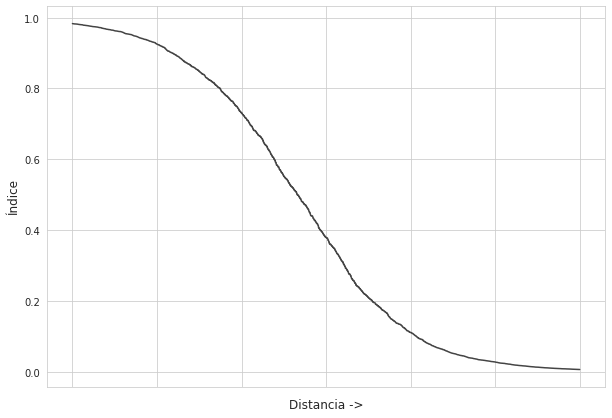

In [26]:
df_tmp = pd.DataFrame(np.random.randint(0,5000,size=(10000,1)), columns=list('A'))
df_tmp['ind_A'] = df_tmp.apply (lambda row: 1 / (1 + math.exp( 0.00627778 * (row.loc['A'] - 650 ))), axis=1)


fig,ax = plt.subplots(figsize=(10,7))
df_tmp.sort_values(by='ind_A', ascending=False, inplace=True)
df_tmp.reset_index(inplace=True)
df_tmp.drop(columns=['index'], inplace=True)
#ax.axes.get_xaxis().set_visible(False)
#Etiquetas
plt.ylabel('Índice', fontsize=12)
ax.set_xlabel('Distancia ->', fontsize=12)
ax.set_xticklabels([])
#plot
df_tmp.iloc[:3000].ind_A.plot(color='#444444', ax=ax)

### Territory

In [22]:
edges_query =  f"SELECT * FROM osmnx.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
edges = aup.gdf_from_query(edges_query, geometry_col='geometry')

<AxesSubplot:>

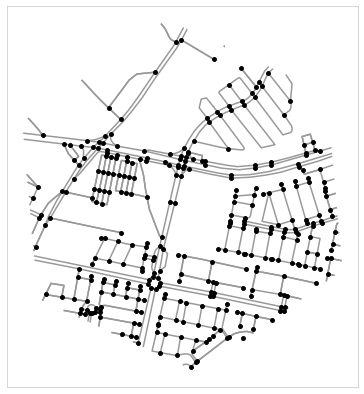

In [29]:
hex_bins = hex_bins.set_crs("EPSG:4326")
nodes_c = gpd.clip(nodes, hex_bins.loc[hex_bins.hex_id_8=='88498eac91fffff'])
edges_c = gpd.clip(edges, hex_bins.loc[hex_bins.hex_id_8=='88498eac91fffff'])

fig,ax = plt.subplots(figsize=(10,7))
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
nodes_c.plot(ax=ax, color='black', markersize=15, zorder=1)
edges_c.plot(ax=ax, color='#999999', zorder=-1)

### Population vs territory

In [51]:
 cities = {"Aguascalientes":{"mpos":["01001","01005","01011"],"edo":["01"]},
"Tijuana":{"mpos":["02003", "02004", "02005"],"edo":["02"]},
"León":{"mpos":["11020", "11037"],"edo":["11"]},
"Pachuca":{"mpos":["13022", "13039", "13048", "13051", "13052", "13082", "13083"],"edo":["13"]},
"Guadalajara":{"mpos":["14002", "14039", "14044", "14051", "14070", "14097", "14098", "14101", "14120", "14124"],"edo":["14"]},
"Toluca":{"mpos":["15005", "15018", "15027", "15051", "15054", "15055", "15062", "15067", "15072", "15073", "15076", "15087", "15090", "15106", "15115", "15118"],"edo":["15"]},
"Morelia":{"mpos":["16022", "16053", "16088"],"edo":["16"]},
"Monterrey":{"mpos":["19001", "19006", "19009", "19010", "19012", "19018", "19019", "19021", "19025", "19026", "19031", "19039", "19041", "19045", "19046", "19047", "19048", "19049"],"edo":["19"]},
"Puebla":{"mpos":["21001", "21015", "21034", "21041", "21048", "21060", "21074", "21090", "21106", "21114", "21119", "21122", "21125", "21132", "21136", "21140", "21143", "21163", "21181", "29015", "29017", "29019", "29023", "29025", "29027", "29028", "29029", "29032", "29041", "29044", "29051", "29053", "29054", "29056", "29057", "29058", "29059"],"edo":["21", "29"]},
"Querétaro":{"mpos":["11004", "22006", "22008", "22011", "22014"],"edo":["11", "22"]},
"Cancún":{"mpos":["23003", "23005"],"edo":["23"]},
"Mérida":{"mpos":["31002", "31013", "31038", "31041", "31050", "31063" , "31090", "31093", "31095", "31100", "31101"],"edo":["31"]},
"CDMX":{"mpos":["09002", "09003", "09004", "09005", "09006", "09007", "09008", "09009", "09010", "09011", "09012", "09013", "09014", "09015", "09016", "09017"],"edo":["09"]}
}

In [3]:
df = pd.read_json("../scripts/Metropolis_CVE.json")

In [4]:
df.loc['mpos','CDMX'] = [[["09002", "09003", "09004", "09005", "09006", "09007", "09008", "09009", "09010", "09011", "09012", "09013", "09014", "09015", "09016", "09017"]]]

In [5]:
df_idx = pd.DataFrame(columns=['city','territory',
                               'w_territory','w_population_t',
                               'w_population','population'])
hex_all = gpd.GeoDataFrame()

i = 0
for city in list(df.columns.unique()):
    
    hex_bins_idx = gpd.GeoDataFrame()
    hex_bins_pop = gpd.GeoDataFrame()

    if city == 'CDMX':
        city_codes = df[city]['mpos'][0]
    else:
        city_codes = df[city]['mpos']

    for c in city_codes:
        query = f"SELECT * FROM processed.hex_bins_index_2020 WHERE \"CVEGEO\" LIKE \'{c}%%\'"
        hex_bins_idx = hex_bins_idx.append(aup.gdf_from_query(query, geometry_col='geometry'))
        query = f"SELECT pobtot,hex_id_8,geometry FROM processed.hex_bins_pop WHERE \"CVEGEO\" LIKE \'{c}%%\'"
        hex_bins_pop = hex_bins_pop.append(aup.gdf_from_query(query, geometry_col='geometry'))

    hex_mrg = pd.merge(hex_bins_idx, hex_bins_pop, on='hex_id_8')

    #node counter for weighted index
    node_sum = hex_mrg['node_count'].sum()
    #calculating weigths by hex_bin
    hex_mrg['wAcc'] = hex_mrg.idx_accessibility * hex_mrg['node_count']
    #calculating input for weigthed average
    hex_mrg['idx_accessibility_wavg'] = hex_mrg['wAcc']/node_sum

    w_ter_idx = round(hex_mrg.idx_accessibility_wavg.sum(), 2)

    pop_idx_t = round(hex_mrg.loc[
        (hex_mrg.pobtot>0),'idx_accessibility_wavg'].sum(), 2)

    pobtot = hex_mrg.pobtot.sum()
    hex_mrg['wPob'] = hex_mrg.idx_accessibility * hex_mrg.pobtot
    hex_mrg['idx_accessibility_wAvgPob'] = hex_mrg.wPob / pobtot
    w_pop_idx = hex_mrg.idx_accessibility_wAvgPob.sum()

    ter_idx = hex_mrg.idx_accessibility.mean()
    pob_idx = hex_mrg.loc[hex_mrg.pobtot>0]['idx_accessibility'].mean()

    df_idx.loc[i] = [city, ter_idx, w_ter_idx, 
                     pop_idx_t, w_pop_idx, pob_idx]

    hex_mrg['city'] = city
    hex_mrg.rename(columns={'geometry_x':'geometry'}, inplace=True)
    hex_all = hex_all.append(hex_mrg)

    print(f'{city} finished, id: {i}')

    i += 1

Aguascalientes finished, id: 0
Ensenada finished, id: 1
Mexicali finished, id: 2
Tijuana finished, id: 3
La Paz finished, id: 4
Campeche finished, id: 5
Laguna finished, id: 6
Monclova finished, id: 7
Piedras Negras finished, id: 8
Saltillo finished, id: 9
Colima finished, id: 10
Tecoman finished, id: 11
Tapachula finished, id: 12
Tuxtla finished, id: 13
Chihuahua finished, id: 14
Delicias finished, id: 15
Parrral finished, id: 16
Juarez finished, id: 17
ZMVM finished, id: 18
Durango finished, id: 19
Celaya finished, id: 20
Guanajuato finished, id: 21
Leon finished, id: 22
Moroleon finished, id: 23
San Francisco finished, id: 24
Acapulco finished, id: 25
Chilpancingo finished, id: 26
Pachuca finished, id: 27
Tula finished, id: 28
Tulancingo finished, id: 29
Guadalajara finished, id: 30
Ocotlan finished, id: 31
Vallarta finished, id: 32
Tianguistenco finished, id: 33
Toluca finished, id: 34
Piedad finished, id: 35
Morelia finished, id: 36
Zamora finished, id: 37
Cuautla finished, id: 38

In [6]:
df_idx

,city,territory,w_territory,w_population_t,w_population,population
0,Aguascalientes,0.118568,0.44,0.43,0.624584,0.445318
1,Ensenada,0.071065,0.35,0.34,0.525805,0.390479
2,Mexicali,0.093623,0.41,0.41,0.581116,0.409668
3,Tijuana,0.169743,0.49,0.49,0.590543,0.462582
4,La Paz,0.058302,0.33,0.32,0.602959,0.353236
...,...,...,...,...,...,...
70,Veracruz,0.141345,0.51,0.50,0.705618,0.546000
71,Xalapa,0.136953,0.49,0.47,0.697878,0.476932
72,Merida,0.151239,0.43,0.43,0.583934,0.409944
73,Zacatecas,0.108069,0.42,0.41,0.576314,0.358310


In [7]:
df_idx['w_territory_manual'] = np.nan
df_idx['w_popterr_manual'] = np.nan
df_idx['pobtot'] = np.nan
for c_2 in df_idx.city.unique():
    hex_city_tmp = hex_all.loc[(hex_all.city==c_2)].copy()
    #node counter for weighted index
    node_sum = hex_city_tmp['node_count'].sum()
    #calculating weigths by hex_bin
    hex_city_tmp['wAcc'] = hex_city_tmp.idx_accessibility * hex_city_tmp['node_count']
    #calculating input for weigthed average
    hex_city_tmp['idx_Acc_m'] = (hex_city_tmp['wAcc']/node_sum)
    w_t_idx_m = hex_city_tmp['idx_Acc_m'].sum()
    w_pt_idx_m = hex_city_tmp.loc[hex_city_tmp.pobtot>0]['idx_Acc_m'].sum()
    df_idx.loc[df_idx.city==c_2,'w_territory_manual'] = w_t_idx_m
    df_idx.loc[df_idx.city==c_2,'w_popterr_manual'] = w_pt_idx_m
    df_idx.loc[df_idx.city==c_2,'pobtot'] = hex_city_tmp.pobtot.sum()

In [10]:
df_idx_city_size = df_idx.loc[df_idx.pobtot>=500000].copy()
df_idx_city_size.sort_values(by='w_territory_manual',ascending=False, inplace=True)
df_idx_city_size

,city,territory,w_territory,w_population_t,w_population,population,w_territory_manual,w_popterr_manual,pobtot
74,CDMX,0.495704,0.73,0.73,0.794790,0.653658,0.734414,0.733355,9.175834e+06
18,ZMVM,0.324165,0.62,0.61,0.734667,0.526292,0.617144,0.612052,2.098868e+07
17,Juarez,0.180888,0.56,0.56,0.606816,0.456206,0.562957,0.560477,1.492930e+06
30,Guadalajara,0.209183,0.55,0.54,0.677183,0.490277,0.546690,0.538932,5.077468e+06
41,Monterrey,0.199461,0.54,0.54,0.659037,0.473088,0.543298,0.535762,5.262621e+06
52,Culiacan,0.115368,0.53,0.52,0.691515,0.542420,0.532071,0.520795,8.813830e+05
48,Cancun,0.219298,0.52,0.51,0.656826,0.440183,0.522644,0.514328,9.128351e+05
61,Reynosa,0.113764,0.52,0.52,0.625698,0.513507,0.521901,0.519090,8.104663e+05
6,Laguna,0.164569,0.52,0.52,0.683538,0.510070,0.520017,0.516054,1.250804e+06
70,Veracruz,0.141345,0.51,0.50,0.705618,0.546000,0.509682,0.497677,8.160034e+05


In [12]:
df_idx_city_size.to_csv('../data/processed/AccIndex_ByCity_Mid-LargeCities.csv')

In [37]:
df_idxCitySize_NoCDMX = df_idx_city_size.drop(74)
print(df_idxCitySize_NoCDMX.shape)
df_idxCitySize_NoCDMX.head(2)

(34, 9)


,city,territory,w_territory,w_population_t,w_population,population,w_territory_manual,w_popterr_manual,pobtot
25,Acapulco,0.107967,0.38,0.38,0.545612,0.364363,0.384132,0.380163,706988.389463
2,Mexicali,0.093623,0.41,0.41,0.581116,0.409668,0.410698,0.405475,943417.994961


In [38]:
df_idxCitySize_NoCDMX.city.unique()

array(['Acapulco', 'Mexicali', 'Tlaxcala', 'Queretaro', 'Villahermosa',
       'Toluca', 'Cuernavaca', 'Pachuca', 'Merida', 'Tuxtla', 'Celaya',
       'Saltillo', 'Chihuahua', 'Aguascalientes', 'Morelia', 'Matamoros',
       'Leon', 'Hermosillo', 'Xalapa', 'Durango', 'Tijuana', 'Oaxaca',
       'SLP', 'Tampico', 'Puebla', 'Veracruz', 'Laguna', 'Reynosa',
       'Cancun', 'Culiacan', 'Monterrey', 'Guadalajara', 'Juarez', 'ZMVM'],
      dtype=object)

In [39]:
city_rename = {'Juarez':'Juárez','Queretaro':'Querétaro',
              'Merida':'Mérida','Leon':'León','SLP':'San Luis Potosí',
              'Cancun':'Cancún','Culiacan':'Culiacán'}
for c in city_rename:
    df_idxCitySize_NoCDMX.loc[df_idxCitySize_NoCDMX.city==c,'city'] = city_rename[c]

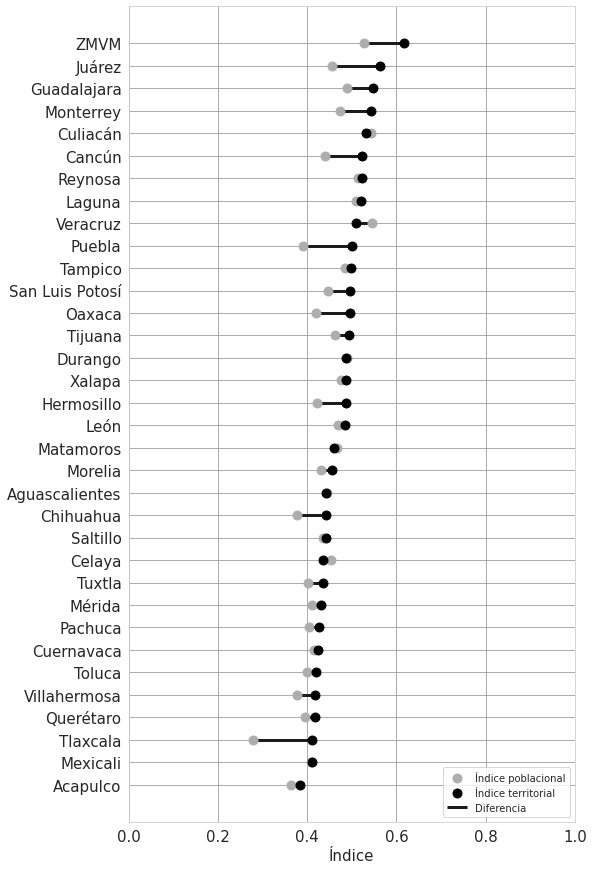

In [47]:
#import seaborn as sns

df_idxCitySize_NoCDMX.sort_values(by='w_territory_manual', inplace=True)

fig = plt.figure(figsize=(8,15))

my_range=range(0,len(df_idxCitySize_NoCDMX))
c
plt.scatter(df_idxCitySize_NoCDMX['population'], 
            my_range, color='#adadad', s=80, alpha=1, zorder=2)

plt.scatter(df_idxCitySize_NoCDMX['w_territory_manual'], 
            my_range, color='black', s=80, alpha=1, zorder=2)

plt.hlines(y=df_idxCitySize_NoCDMX['city'], xmin=df_idxCitySize_NoCDMX['population'], 
           xmax=df_idxCitySize_NoCDMX['w_territory_manual'],linewidth=3, color='#1b1b1b', 
           alpha =1, zorder=1)

#plt.title("Índice de proximidad básica en cuarentena", fontsize=20, x=0.5,y=1.02)

plt.xlabel('Índice', fontsize=15)

plt.ylabel('',fontsize=20)

plt.yticks(fontsize=15)

plt.xticks(fontsize=15)

plt.grid(c='#999999')

plt.xlim(left=0, right=1) 

plt.legend(['Índice poblacional', 'Índice territorial', 'Diferencia'], loc='lower right')

plt.savefig('../output/figures/IndiceAccesibilidad_CiudadesMediasGrandes.png', bbox_inches='tight', dpi=300)
plt.savefig('../output/figures/IndiceAccesibilidad_CiudadesMediasGrandes.svg', bbox_inches='tight')

In [32]:
df_idx.sort_values(by='population',ascending=False, inplace=True)


In [16]:
df_idx

,city,territory,w_territory,w_population_t,w_population,population,w_territory_manual,w_popterr_manual,pobtot
0,Aguascalientes,0.118568,0.44,0.43,0.624584,0.445318,0.443304,0.433273,1.042106e+06
1,Ensenada,0.071065,0.35,0.34,0.525805,0.390479,0.348223,0.338107,3.950665e+05
2,Mexicali,0.093623,0.41,0.41,0.581116,0.409668,0.410698,0.405475,9.434180e+05
3,Tijuana,0.169743,0.49,0.49,0.590543,0.462582,0.494035,0.485635,2.074455e+06
4,La Paz,0.058302,0.33,0.32,0.602959,0.353236,0.333871,0.322144,2.694003e+05
...,...,...,...,...,...,...,...,...,...
70,Veracruz,0.141345,0.51,0.50,0.705618,0.546000,0.509682,0.497677,8.160034e+05
71,Xalapa,0.136953,0.49,0.47,0.697878,0.476932,0.486239,0.473545,6.689312e+05
72,Merida,0.151239,0.43,0.43,0.583934,0.409944,0.431850,0.425926,1.237861e+06
73,Zacatecas,0.108069,0.42,0.41,0.576314,0.358310,0.419077,0.412167,3.681760e+05


### Querétaro index

In [30]:
 cities = {
"Queretaro":{"mpos":["11004", "22006", "22008", "22011", "22014"],"edo":["11", "22"]},
"CDMX":{"mpos":["09002", "09003", "09004", "09005", "09006", "09007", "09008", "09009", "09010", "09011", "09012", "09013", "09014", "09015", "09016", "09017"],"edo":["09"]}
}

In [31]:
city_codes = cities['Queretaro']['mpos']

query = f'SELECT * FROM processed.hex_bins_index_2020 WHERE "CVEGEO" IN {str(tuple(city_codes))}'
hex_qto = aup.gdf_from_query(query, geometry_col='geometry')

query = f'SELECT * FROM marco.mpos_2020 WHERE "CVEGEO" IN {str(tuple(city_codes))}'
mun_qto = aup.gdf_from_query(query, geometry_col='geometry')

<AxesSubplot:>

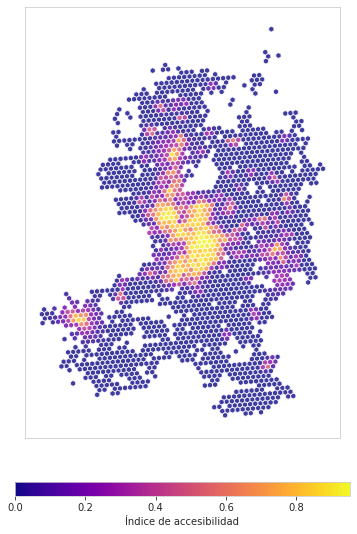

In [48]:
fig,axes = plt.subplots(2,1, figsize=(6,9), gridspec_kw={"height_ratios":[0.96, 0.03]})
ax = axes[0]
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#hex_qto.plot('idx_accessibility',ax=ax,alpha=0.65)
#edges.plot(color='white', linewidth=0.035, ax=ax, zorder=2)
hex_qto.plot(ax=ax, column='idx_accessibility', alpha=0.8, cax=axes[1], legend=True, cmap='plasma',
             legend_kwds={'label': "Índice de accesibilidad",'orientation': "horizontal"})

### CDMX index

In [49]:
city_codes = cities['CDMX']['mpos']

query = f'SELECT * FROM processed.hex_bins_index_2020 WHERE "CVEGEO" IN {str(tuple(city_codes))}'
hex_cdmx = aup.gdf_from_query(query, geometry_col='geometry')

query = f'SELECT * FROM marco.mpos_2020 WHERE "CVEGEO" IN {str(tuple(city_codes))}'
mun_cdmx = aup.gdf_from_query(query, geometry_col='geometry')

<AxesSubplot:>

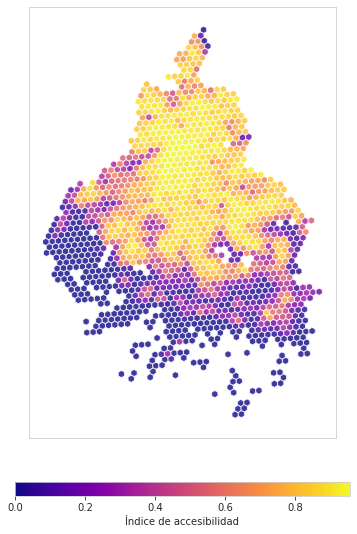

In [50]:
fig,axes = plt.subplots(2,1, figsize=(6,9), gridspec_kw={"height_ratios":[0.96, 0.03]})
ax = axes[0]
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#hex_qto.plot('idx_accessibility',ax=ax,alpha=0.65)
#edges.plot(color='white', linewidth=0.035, ax=ax, zorder=2)
hex_cdmx.plot(ax=ax, column='idx_accessibility', alpha=0.8, cax=axes[1], legend=True, cmap='plasma',
             legend_kwds={'label': "Índice de accesibilidad",'orientation': "horizontal"})